In [1]:
# this jupyter file is used to predict the classification task of "orzone".

In [2]:
import time
import pandas as pd
import numpy as np

In [3]:
# data file
File1 = "ozone_onehr.csv"
File2 = "ozone_eighthr.csv"

In [4]:
# in these two datasets, i use two algorithm, one is decision tree and the other is LogisticRegression

In [5]:
# The reason why i choose logisticRegression:
# Before choosing some models, using logisticRegression to make a base model is a good idea.
# And it is easy relatively.
# the reason why i choose desicion tree:
# 1、 it can be used for both classification and regression problems
# 2、 over fitting might be handled because there are many trees
# 3、can deal with missing value

In [6]:
#data file：ozone_onehr.csv
# get data from file
file_name = File1
dataset = pd.read_csv(file_name)

In [7]:
# find all "?" and make it np.nan
dataset = dataset.replace('?', np.nan).infer_objects()
object_of_file = [col for col in dataset.columns if dataset[col].dtype == 'object']
object_of_file.pop(object_of_file.index('Date'))
# 
dataset[object_of_file] = dataset[object_of_file].applymap(float)
df_0 = dataset

In [8]:
# fill all nan data,i use mean value to fill nan data 
# Calculate the mean value of each column of characteristic data respectively, and fill in the characteristic 
# value of this column with the mean value
from collections import Counter
df = df_0
nan_cols = df.columns[df.isnull().sum() > 0]
values = {col:df[col].mean() for col in nan_cols}
df_0 = df.fillna(value=values)

In [9]:
df_0.head()


,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Orzone
0,01/01/1998,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,...,0.15000,10.670000,-1.560000,5795.000000,-12.100000,17.900000,10330.000000,-55.000000,0.00,0
1,01/02/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48000,8.390000,3.840000,5805.000000,14.050000,29.000000,10275.000000,-55.000000,0.00,0
2,01/03/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.60000,6.940000,9.800000,5790.000000,17.900000,41.300000,10235.000000,-40.000000,0.00,0
3,01/04/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49000,8.730000,10.540000,5775.000000,31.150000,51.700000,10195.000000,-40.000000,2.08,0
4,01/05/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,0.30467,9.867313,0.831892,5818.898515,10.510812,37.388366,10164.180664,-0.130416,0.58,0


In [10]:
# split the dataset into train and text
# i try to delet "Date", i think it is redudent and useless
# And i also classify the data to make it as standard normal distribution N(0,1)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LogisticRegression as lrc
from sklearn.metrics import accuracy_score, roc_curve


def data_split(df):
    data1 = df.drop("Date", axis=1)
    data = data1.values
    X, y = data[:, :-1], data[:, -1]
    ss = StandardScaler()
    X = ss.fit_transform(X)
    # I split train and text data into 7:3 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    return X_train, X_test, y_train, y_test

In [11]:
# this part learn from https://blog.csdn.net/qq_30638831/article/details/80200684 and https://blog.csdn.net/u010758410/article/details/78158781

In [12]:
X_train, X_test, y_train, y_test = data_split(df_0)


In [13]:
# Then i use grid to find the best parameter and best score
    # Explain gird: Each parameter combination is traversed, and ten fold cross validation is performed on the training data set. 
    # Select the parameter with the highest average accuracy of cross validation as the optimal parameter
def grid_search(x_, y_, model, args):
    grid = GridSearchCV(model, param_grid=args, cv=10)
    grid.fit(x_, y_)
    return grid.best_params_, grid.best_score_



In [14]:
# I make the parameter search in this range, and then get the best param

# Search range of random forest parameters
RFC_ARGS = {"n_estimators": [100, 300, 500],
            "criterion": ["gini", "entropy"]}
# Search range of logistic regression
LRC_ARGS = {"penalty": ['l1', 'l2'],
            "C": [0.02, 0.01, 0.1, 0.5]}

def model_train(model, args, X_train, y_train):
#train the model on all training samples with the selected parameters, and calculate the time spent on the model and the training accuracy rate
    # param search
    print(f"{model.__name__:-^80}")
    best_params, best_score = grid_search(X_train, y_train, model(random_state=1), args)
    print(f"the best paramsters by grid-search is:{best_params}")
    print(f"the best paramsters is:{best_score}")
    # train
    start_time = time.time()
    clf = model(random_state=1, **best_params)
    clf.fit(X_train, y_train)
    # this time i add time counter to compare the difference of two models
    # From ROC, we know the accuracy is so similar, so we need to find other different factors
   
    timess = time.time()-start_time
    # predict
    train_accurate = accuracy_score(y_train, clf.predict(X_train))
    # display
    print(f"time cost of model training: {timess:.6} S")
    print(f"train accuracy:{train_accurate:.3%}")
    return clf

In [15]:
# reference of gridsearch code :
# https://blog.csdn.net/tensorflow66/article/details/79772304
# and http://ju.outofmemory.cn/entry/329943 and https://blog.csdn.net/shinsonwu/article/details/85239730

In [16]:
import warnings
warnings.filterwarnings("ignore")

# train the random forest in the first dataset
rf_classifier1 = model_train(rfc, RFC_ARGS, X_train, y_train)
# train the logistic regression in the first dataset
lr_classifier1 = model_train(lrc, LRC_ARGS, X_train, y_train)


-----------------------------RandomForestClassifier-----------------------------
the best paramsters by grid-search is:{'criterion': 'entropy', 'n_estimators': 500}
the best paramsters is:0.9712676056338028
time cost of model training: 1.60297 S
train accuracy:100.000%
-------------------------------LogisticRegression-------------------------------
the best paramsters by grid-search is:{'C': 0.5, 'penalty': 'l2'}
the best paramsters is:0.9729577464788732
time cost of model training: 0.0229385 S
train accuracy:97.465%


In [17]:
import matplotlib.pyplot as plt

def validation(clfs, X_test, y_test):
# We calculated and compared the accuracy of different models in training data
    for clf in clfs:
        test_accu = accuracy_score(y_test, clf.predict(X_test))
        print(f"test accuracy of {clf.__class__.__name__} is: {test_accu:.3%}")
    
    # and train roc to compare
    fig, ax = plt.subplots(figsize=(8, 6))
    fig.suptitle("ROC")
    for clf in clfs:
        fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        ax.plot(fpr, tpr, label=clf.__class__.__name__)
    ax.legend(loc="best")
    ax.set_xlabel("fpr")
    ax.set_ylabel("tpr")
    plt.show()


test accuracy of RandomForestClassifier is: 96.846%
test accuracy of LogisticRegression is: 97.109%


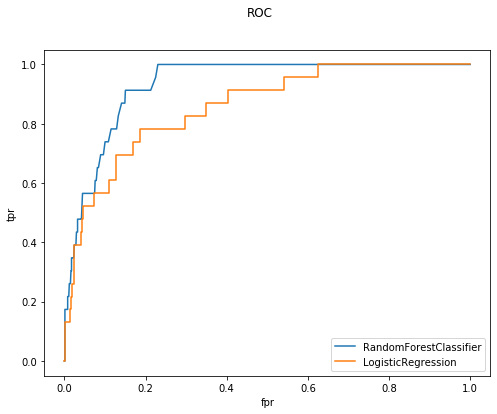

In [18]:

validation([rf_classifier1, lr_classifier1], X_test, y_test)

In [19]:
# Then we get the roc index.
# test accuracy of RandomForestClassifier is: 96.846%
# test accuracy of LogisticRegression is: 97.109%

In [20]:
# Let's do the same thing to the second dataset

In [21]:
# datafile：ozone_eighthr.csv
print("For the ozone_eighthr:")
file_name = File2
dataset = pd.read_csv(file_name)
dataset = dataset.replace('?', np.nan).infer_objects()
object_of_file = [col for col in dataset.columns if dataset[col].dtype == 'object']
object_of_file.pop(object_of_file.index('Date'))
dataset[object_of_file] = dataset[object_of_file].applymap(float)
df_0 = dataset

df = df_0
#fill the nan
nan_cols = df.columns[df.isnull().sum() > 0]
values = {col:df[col].mean() for col in nan_cols}
df_0 = df.fillna(value=values)
print(Counter(df_0['Orzone'].values))

For the ozone_eighthr:
Counter({0: 2374, 1: 160})


-----------------------------RandomForestClassifier-----------------------------
the best paramsters by grid-search is:{'criterion': 'entropy', 'n_estimators': 100}
the best paramsters is:0.9435984207557812
time cost of model training: 0.411898 S
train accuracy:99.944%
-------------------------------LogisticRegression-------------------------------
the best paramsters by grid-search is:{'C': 0.1, 'penalty': 'l2'}
the best paramsters is:0.943034404963339
time cost of model training: 0.0169544 S
train accuracy:94.529%
test accuracy of RandomForestClassifier is: 94.218%
test accuracy of LogisticRegression is: 94.350%


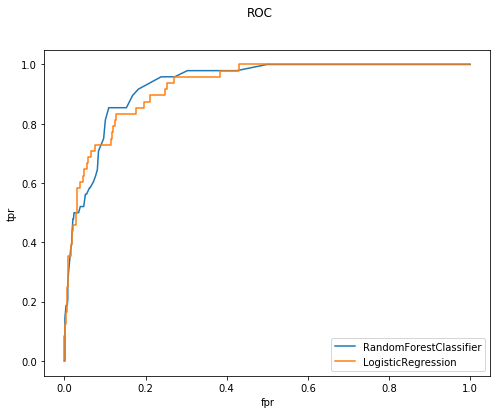

In [22]:
X_train, X_test, y_train, y_test = data_split(df_0)
rf_classifier2 = model_train(rfc, RFC_ARGS, X_train, y_train)
lr_classifier2 = model_train(lrc, LRC_ARGS, X_train, y_train)
validation([rf_classifier2, lr_classifier2], X_test, y_test)

In [23]:
# Thus we can get conclusions:
# 1. Both models have achieved very high accuracy on both data sets.
# 2. However, due to the large difference between the number of positive and negative samples, and a lot of loss data, 
# these factors may lead the prediciton not accuracy,
# However by comparing ROC curve, we find that randomforest classifier is better than logistic regression model
# and they both get very high accuracy
# 3. Although randomforestclassifier is better than logistregression in performance, 
# its training time is much loger
# So, if we want to train a model with very big data, we could choose logistic first , if the data is not so big, we could use decision tree 